Space & Time coverages
============

This notebook shows:

1. How to **create** Space-Time coverages of the 2MASS image catalog and the XMM_DR8 catalog
2. How to **perform logical operations** (e.g. intersection) of two Space-Time coverages
3. How to **filter** a catalog by a Space-Time coverage
4. How to **save** a Space-Time coverage in a FITS file
5. How to **vizualize** Space-Time coverages within a specific time frame

------------------------------------------------------------------
## 1. Space-Time coverages *creation* of 2MASS and XMM_DR8

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
from mocpy import MOC, WCS
from astropy.coordinates import ICRS
import time
import numpy as np
from astropy import units as u
from astropy.table import Table
from astropy.coordinates import Angle, SkyCoord
import ipywidgets as widgets

Creation of the Space-Time coverage of 2MASS at the depth (time, space) = 10, 7 i.e.:
- a **time** resolution of ~3 days
- a **spatial** resolution of ~27 arcsecs

In [18]:
# Loading the data
two_mass_data = Table.read('./2MASS-list-images.fits.gz', format='fits')
from astropy.time import Time
# Definition of the times, longitudes and latitudes
times_2mass = Time(two_mass_data['mjd'].data, format='mjd', scale='tdb')
lon_2mass = two_mass_data['ra'].quantity
lat_2mass = two_mass_data['dec'].quantity

In [19]:
# Creation of the STMOC
from mocpy import STMOC
time_depth = 10
spatial_depth = 7
%time two_mass = STMOC.from_times_positions(times_2mass, time_depth, lon_2mass, lat_2mass, spatial_depth)

CPU times: user 5.23 s, sys: 274 ms, total: 5.5 s
Wall time: 1.9 s


In [20]:
print("Time of the first observation: ", two_mass.min_time.iso)
print("Time of the last observation: ", two_mass.max_time.iso)

Time of the first observation:  1997-06-03 20:25:27.103
Time of the last observation:  2001-02-18 03:38:35.462


---------------------------------------------
## Query a STMOC by a time range

Let's query the ST-MOC generated from the 2MASS image catalog.

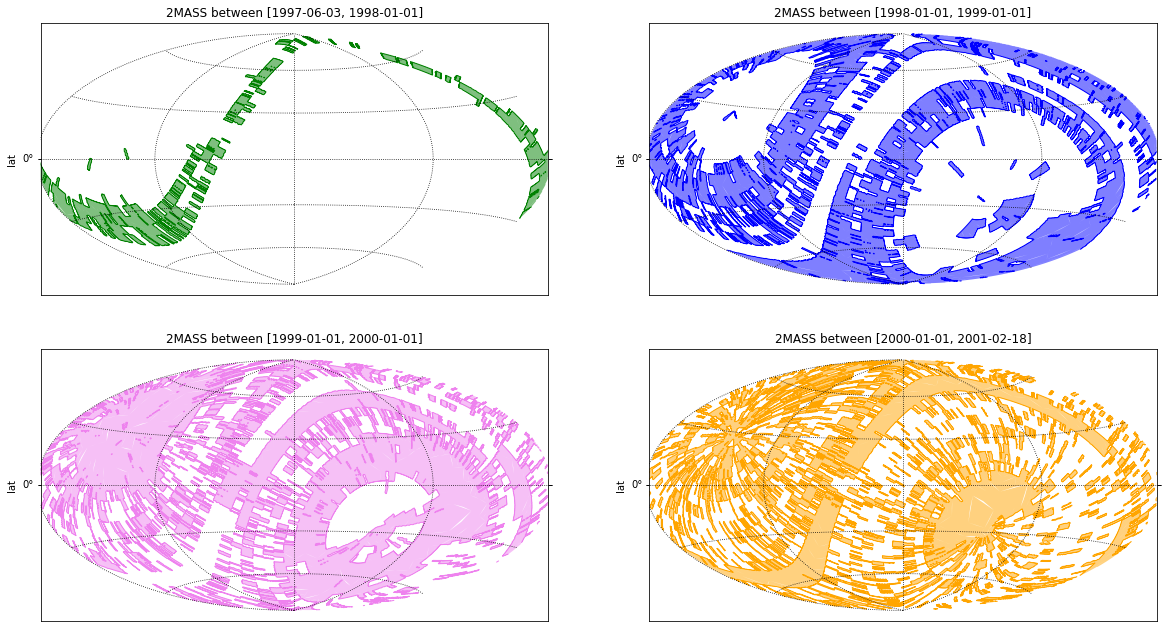

In [21]:
times = [("1997-06-03", "1998-01-01"),
         ("1998-01-01", "1999-01-01"),
         ("1999-01-01", "2000-01-01"),
         ("2000-01-01", "2001-02-18")]

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20, 11))

with WCS(fig, 
         fov=320 * u.deg,
         center=SkyCoord(0, 0, unit='deg', frame='galactic'),
         coordsys="galactic",
         rotation=Angle(0, u.degree),
         projection="AIT") as wcs:
    time_range = Time([times[0]], format='iso', scale='tdb')

    ax = fig.add_subplot(221, projection=wcs)
    moc_2mass = two_mass.project_on_second_dimension(time_range)
    ax.grid(color="black", linestyle="dotted")
    ax.set_title('2MASS between [%s, %s]' % (times[0][0], times[0][1]))
    ax.set_xlabel('lon')
    ax.set_ylabel('lat')
    # Call fill with a matplotlib axe and the `~astropy.wcs.WCS` wcs object.
    moc_2mass.fill(ax=ax, wcs=wcs, alpha=0.5, fill=True, linewidth=0, color="green")
    moc_2mass.border(ax=ax, wcs=wcs, linewidth=1, color="green")
    
    time_range = Time([times[1]], format='iso', scale='tdb')
    ax = fig.add_subplot(222, projection=wcs)
    moc_2mass = two_mass.project_on_second_dimension(time_range)
    ax.grid(color="black", linestyle="dotted")
    ax.set_title('2MASS between [%s, %s]' % (times[1][0], times[1][1]))
    ax.set_xlabel('lon')
    ax.set_ylabel('lat')
    ax.set_clip_on(True)
    # Call fill with a matplotlib axe and the `~astropy.wcs.WCS` wcs object.
    moc_2mass.fill(ax=ax, wcs=wcs, alpha=0.5, fill=True, linewidth=0, color="b")
    moc_2mass.border(ax=ax, wcs=wcs, linewidth=1, color="b")
    
    time_range = Time([times[2]], format='iso', scale='tdb')
    ax = fig.add_subplot(223, projection=wcs)
    moc_2mass = two_mass.project_on_second_dimension(time_range)
    ax.grid(color="black", linestyle="dotted")
    ax.set_title('2MASS between [%s, %s]' % (times[2][0], times[2][1]))
    ax.set_xlabel('lon')
    ax.set_ylabel('lat')
    # Call fill with a matplotlib axe and the `~astropy.wcs.WCS` wcs object.
    moc_2mass.fill(ax=ax, wcs=wcs, alpha=0.5, linewidth=0, fill=True, color="violet")
    moc_2mass.border(ax=ax, wcs=wcs, linewidth=1, color="violet")
    
    time_range = Time([times[3]], format='iso', scale='tdb')
    ax = fig.add_subplot(224, projection=wcs)
    moc_2mass = two_mass.project_on_second_dimension(time_range)
    ax.grid(color="black", linestyle="dotted")
    ax.set_title('2MASS between [%s, %s]' % (times[3][0], times[3][1]))
    ax.set_xlabel('lon')
    ax.set_ylabel('lat')
    # Call fill with a matplotlib axe and the `~astropy.wcs.WCS` wcs object.
    moc_2mass.fill(ax=ax, wcs=wcs, alpha=0.5, linewidth=0, fill=True, color="orange")
    moc_2mass.border(ax=ax, wcs=wcs, linewidth=1, color="orange", alpha=1)

plt.savefig('2mass_through_times.png')
#plt.show()

Creation of the Space-Time coverage of XMM_DR8 at the depth (time, space) = 10, 7

In [22]:
# Loading & preparing the data
xmm_dr8_data = Table.read('../resources/STMOC/vizier_votable.b64')
times_xmm = Time(xmm_dr8_data['MJD0'].data, format='mjd', scale='tdb')
lon_xmm = xmm_dr8_data['RA_ICRS'].quantity
lat_xmm = xmm_dr8_data['DE_ICRS'].quantity

In [38]:
# Create the STMOC
%time xmm_dr8_stmoc = STMOC.from_times_positions(times_xmm, time_depth, lon_xmm, lat_xmm, spatial_depth)

CPU times: user 306 ms, sys: 48.2 ms, total: 354 ms
Wall time: 155 ms


------------------------------------------------------------------
## 2. Intersection between the 2MASS and XMM_DR8 Space-Time coverages

ST-MOCs are very convinient when it comes to perform logical operations between them (as it is already possible with spatial footprints).

As an example, it is possible to **retrieve the areas that have been observed at the same time by the 2MASS and XMM survey**! It benefits from the good performance of MOC (thanks to its core functions written in Rust).

In [24]:
# Compute their intersection and check that it is not empty
%time xmm_inter_2mass = xmm_dr8_stmoc.intersection(two_mass)
assert(not xmm_inter_2mass.is_empty())

print("Time of the first observation:", xmm_inter_2mass.min_time.iso)
print("Time of the last observation:", xmm_inter_2mass.max_time.iso)

CPU times: user 835 µs, sys: 0 ns, total: 835 µs
Wall time: 840 µs
Time of the first observation: 2000-02-18 06:49:16.163
Time of the last observation: 2000-11-05 03:55:44.532


-------------------------------------------
## 3. Filter catalogs by a Space-Time coverage

STMOCs can be used to retrieve the sources in 2MASS and XMM_DR8 that have
been observed at the same time (depth 10 => a ~3 days time resolution) and
at the same location (depth 7 => 27 arcsec spatial resolution)

In [27]:
# Filtering a 4.8M rows table is quite fast
%time mask_xmm = xmm_inter_2mass.contains(times_xmm, lon_xmm, lat_xmm)
sources_xmm = xmm_dr8_data[mask_xmm]

print("\n {} sources in XMM\n".format(len(sources_xmm)))
print(sources_xmm)

CPU times: user 196 ms, sys: 0 ns, total: 196 ms
Wall time: 63.6 ms

 100 sources in XMM

 RA_ICRS    DE_ICRS      MJD0    recno 
   deg        deg         d            
---------- ---------- ---------- ------
 54.181699   0.604013 51592.5937  89571
 54.189898   0.605876 51592.5937  89593
 54.197439   0.589064 51592.5937  89616
 54.197446   0.637448 51592.5937  89617
 54.198288   0.602718 51592.5937  89619
 54.201239   0.588460 51592.5937  89629
 54.201833   0.610514 51592.5937  89630
 54.204969   0.593950 51592.5937  89640
 54.205137   0.571247 51592.5937  89641
 54.205956   0.541889 51592.5937  89643
       ...        ...        ...    ...
122.514317  76.043805 51852.8680 178302
122.682826  76.066925 51852.8680 178602
122.740531  76.065955 51852.8680 178696
122.744397  76.045155 51852.8680 178703
122.793540  76.107989 51852.8680 178790
122.802589  76.052934 51852.8680 178803
122.927386  75.823211 51852.8680 178964
123.063435  75.918958 51852.8680 179052
123.172708  76.102680 51852.86

One can then use astroquery.vizier to get more informations about the filtered sources.

In [28]:
xmm_skycoords = SkyCoord(sources_xmm['RA_ICRS'].data, sources_xmm['DE_ICRS'].data, unit="deg", frame=ICRS())

from astroquery.vizier import Vizier
from astropy.coordinates import Angle
result = Vizier.query_region(xmm_skycoords, radius=Angle(0.1, "arcsec"), catalog='IX/55/xmm3r8s')
result[0]

_q,_3XMM,RA_ICRS,DE_ICRS,srcML,Flux8,e_Flux8,HR1,HR2,HR3,HR4,ext,V,S,Nd,xcatDBdet,xcatDB,IRAP
,,deg,deg,,mW / m2,mW / m2,,,,,arcsec,,,,,,
int32,bytes16,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,uint8,uint8,int16,bytes9,bytes6,bytes4
1,J033643.6+003614,54.181699,0.604013,67.363,2.6823e-14,4.2254e-15,0.192770,-0.010170,-0.799786,-1.000000,0.000000,1,0,1,xcatDBdet,xcatDB,IRAP
2,J033645.5+003621,54.189898,0.605876,52.302,9.7142e-15,3.2946e-15,0.275784,-0.153472,-0.562840,-1.000000,0.000000,1,1,1,xcatDBdet,xcatDB,IRAP
3,J033647.3+003520,54.197439,0.589064,42180,9.7749e-12,1.8025e-13,0.372987,0.023216,-0.508756,-0.779417,16.185900,1,1,1,xcatDBdet,xcatDB,IRAP
4,J033647.3+003814,54.197446,0.637448,46.82,5.2134e-14,1.0262e-14,0.729702,-0.201463,-0.664724,-1.000000,27.865200,0,0,1,xcatDBdet,xcatDB,IRAP
5,J033647.5+003609,54.198288,0.602718,267.59,1.0581e-14,4.3437e-15,0.509140,-0.028953,-0.694076,-1.000000,0.000000,1,1,1,xcatDBdet,xcatDB,IRAP
6,J033648.2+003518,54.201239,0.588460,8130.2,1.4729e-12,6.6818e-14,0.397943,0.078371,-0.490983,-0.378850,0.000000,1,1,1,xcatDBdet,xcatDB,IRAP
7,J033648.4+003637,54.201833,0.610514,548.53,4.4762e-13,2.0978e-14,0.399206,-0.135399,-0.611278,-1.000000,23.101999,1,2,1,xcatDBdet,xcatDB,IRAP
8,J033649.1+003538,54.204969,0.593950,26.982,1.4422e-14,5.8346e-15,0.100453,-0.004605,-0.667067,-1.000000,0.000000,1,1,1,xcatDBdet,xcatDB,IRAP


4. Save the intersection Space-Time coverage into a FITS file
-------------------------------------------------------------

In [29]:
xmm_inter_2mass.write('xmm_inter_2mass_stmoc.fits', format='fits', overwrite=True)

5. Vizualize a Space-Time coverage interactively
------------------------------------------------

- An interactive slider can be used to query the Space-Time coverage with a specific time frame. This results in a
spatial coverage containing the HEALPix cells where the STMOC has data in the given time frame.
- You can change the field of view to zoom (out) if you want. By reducing the FoV you will be able to vizualize the sources in XMM filtered by the intersection Space-Time coverage.

In [33]:
output = widgets.Output()

def update(change):
    global t, output, time_slider
    global last_t1, last_t2
    global moc
    output.clear_output(wait=True)
    
    if change is None:
        new_values = time_slider.value
    else:
        new_values = change.new
    
    new_t1, new_t2 = new_values

    time_range_constraint = Time([[new_t1, new_t2]], format='mjd', scale='tdb')
    # Query the Space-Time coverages with the same time frame
    # This operation returns a spatial coverage and is pretty fast thanks to
    # the data-structure used for storing Space-Time coverages.
    moc_2mass = two_mass.query_by_time(time_range_constraint)
    moc_xmm_dr8 = xmm_dr8_stmoc.query_by_time(time_range_constraint)
    moc_xmm_dr8_inter_2mass = xmm_inter_2mass.query_by_time(time_range_constraint)
    
    # Plot the spatial coverages
    with output:
        fig = plt.figure(111, figsize=(15, 10))
        
        with WCS(fig, 
                 fov=50 * u.deg,
                 center=SkyCoord(140, 30, unit='deg', frame='galactic'),
                 coordsys="galactic",
                 rotation=Angle(0, u.degree),
                 projection="AIT") as wcs:
            ax = fig.add_subplot(1, 1, 1, projection=wcs)
            # Call fill with a matplotlib axe and the `~astropy.wcs.WCS` wcs object.
            moc_2mass.fill(ax=ax, wcs=wcs, alpha=0.5, fill=True, color="green", label="2mass")
            moc_xmm_dr8.fill(ax=ax, wcs=wcs, alpha=0.5, fill=True, color="red", label="xmm_dr8")
            moc_xmm_dr8_inter_2mass.fill(ax=ax, wcs=wcs, alpha=0.5, fill=True, color="blue", label="xmm_dr8 inter 2mass")
            
            # Plot the sources contained into `xmm_inter_2mass`
            skycoords = SkyCoord(sources_xmm['RA_ICRS'].data, sources_xmm['DE_ICRS'].data, unit="deg", frame=ICRS())
            X, Y = SkyCoord.to_pixel(skycoords, wcs)
            ax.scatter(X, Y, color="yellow", alpha=1, marker="x", label="sources from XMM filtered through \nxmm_dr8 inter 2mass", zorder=2)
            
            ax.legend()

        plt.xlabel('GLON')
        plt.ylabel('GLAT')
       
        plt.title('Coverage of 2MASS images, XMM_DR8 and their intersection between MJD %d and %d' % (new_values[0], new_values[1]))
        plt.grid(color="black", linestyle="dotted")
        plt.show()

In [34]:
min_time = int(np.min(two_mass_data['mjd']))-1
max_time = int(np.max(two_mass_data['mjd']))+1

time_slider = widgets.IntRangeSlider(
    value=[51594, 51917],
    min=min_time,
    max=max_time,
    step=1,
    description='MJD interval:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    layout={'width': '90%'}
)

In [35]:
# In blue is a region that has been observed by 2MASS and XMM_DR8 at the same time
time_slider.observe(update, 'value')
update(None)
widgets.VBox([time_slider, output])